In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
import pandas as pd
import requests
import os
import re
import time
import numpy as np
import holidays
from datetime import datetime, timedelta
from scipy.stats import skew, kurtosis
from scipy.optimize import brentq
import scipy.stats as si
from scipy.stats import norm
import matplotlib.patches as patches
import ast
from polygon import RESTClient
from polygon.rest.models.request import RequestOptionBuilder
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
from requests.exceptions import HTTPError
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.patches as patches
API_KEY = "HsOX1rl8t3B1AJfl4O2uqscUp372l7EF"
us_holidays = holidays.US(years=2024)
dst_start = pd.to_datetime('2024-03-10')
dst_end = pd.to_datetime('2024-11-03')
fila =6 # Determina el ancho de la caja en la que buscaremos el máx y el mín.
# no confundir fila que determina la caja del IB con row que determina el núm. de índice cuando la caja es rota.

In [2]:
def get_time_based_on_dst(fecha):
    if dst_start <= fecha <= dst_end:
        return pd.to_datetime('13:30:00').time()
    else:
        return pd.to_datetime('14:30:00').time()

def next_working_day(date, DTE):
    date_obj = datetime.strptime(date, '%Y-%m-%d')
    next_day = date_obj + timedelta(days= DTE)
    while next_day.weekday() in (5, 6) or next_day in us_holidays:
        next_day += timedelta(days=1)
    return next_day.strftime('%Y-%m-%d')

def get_stock_price(ticker, date, expiration_day):
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/minute/{date}/{expiration_day}?adjusted=true&sort=asc&apiKey={API_KEY}"
    #print(url)  # For debugging purposes
    response = requests.get(url)

    if response.status_code == 200:
        try:
            data = response.json()
            if 'results' in data:
                return [(result['t'], result['c']) for result in data['results']]
            else:
                raise ValueError("Response JSON does not contain 'results' key")
        except ValueError as e:
            print(f"Error parsing JSON: {e}")
    else:
        print(f"Request failed with status code {response.status_code}")
    return []

def get_stock_data_for_date(date, DTE):
    expiration_day = next_working_day(date, DTE)
    option_data = get_stock_price(ticker, date, expiration_day)
    df = pd.DataFrame(option_data, columns=['timestamp', 'stock_price'])
    df['fecha'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['time_filter'] = df['fecha'].apply(get_time_based_on_dst)
    df = df[df['fecha'].dt.time >= df['time_filter']]
    df['stock_price'] = round(df['stock_price'],2)
    df = df.reset_index(drop=True)
    df.drop(columns=['time_filter'], inplace=True)
    return df

def days_until_expiration(current_date, expiration_date) -> int:
    # Check if current_date is not a string, convert it to date object
    if not isinstance(current_date, str):
        current_date_obj = current_date
    else:
        current_date_obj = datetime.strptime(current_date, "%Y-%m-%d").date()
    
    # Check if expiration_date is not a string, convert it to date object
    if not isinstance(expiration_date, str):
        expiration_date_obj = expiration_date
    else:
        expiration_date_obj = datetime.strptime(expiration_date, "%Y-%m-%d").date()
    
    # Calculate the difference between the expiration date and the current date
    delta = expiration_date_obj - current_date_obj
    
    # Return the number of days until expiration
    return delta.days

In [3]:
# round ticker step
start = 100
end =   300
step = 2.5
def round_to_closest_strike(price, start, end, step):
    # Generate the strike prices based on start, end, and step
    strikes = [start + i * step for i in range(int((end - start) / step) + 1)]
    
    # Find the closest strike
    closest_strike = min(strikes, key=lambda x: abs(x - price))
    return closest_strike

SUBYACENTE

In [4]:
# ACCION, FECHA Y VENCIMIENTO
ticker = 'AAPL'
date = '2024-08-05'
DTE = 4
df = get_stock_data_for_date(date, DTE)
expiration_day = next_working_day(date, DTE)   
expiration_day = pd.to_datetime(expiration_day).date()
current_stock_price = int(df.iloc[fila]['stock_price'])
print(f"Dia a Analizar:    {date}")
print(f"Expiración:        {expiration_day}")

Dia a Analizar:    2024-08-05
Expiración:        2024-08-09


In [5]:
#days_left = days_until_expiration(date, expiration_day)
#print(f"Days until expiration: {days_left}")

In [6]:
df['date'] = df['fecha'].dt.date
df_at_open = df.groupby('date').first().reset_index()
df_at_open['ticker'] = ticker
df_at_open['strike_ATM'] = None
df_at_open['ATM_C'] = None
df_at_open['ATM_P'] = None
df_at_open['ATM_straddle'] = None
df_at_open

,date,timestamp,stock_price,fecha,ticker,strike_ATM,ATM_C,ATM_P,ATM_straddle
0,2024-08-05,1722864600000,198.78,2024-08-05 13:30:00,AAPL,None,None,None,None
1,2024-08-06,1722951000000,206.22,2024-08-06 13:30:00,AAPL,None,None,None,None
2,2024-08-07,1723037400000,208.27,2024-08-07 13:30:00,AAPL,None,None,None,None
3,2024-08-08,1723123800000,213.06,2024-08-08 13:30:00,AAPL,None,None,None,None
4,2024-08-09,1723210200000,212.24,2024-08-09 13:30:00,AAPL,None,None,None,None


OPTION

In [7]:
def generate_option_ticker(ticker, expiration_day_B, option_type_B, strike_B):
    # Convert expiration_day_B to the desired format (YYMMDD without '20' and '-')
    expiration_day_B_formatted = expiration_day_B.strftime('%y%m%d')

    # Handle the strike_B formatting
    # Convert strike_B to a float, format to two decimal places, remove the decimal point
    strike_B_formatted = f'{float(strike_B):06.2f}'.replace('.', '').zfill(7) + '0'
    
    # Construct the option ticker
    option_ticker_B = f'O:{ticker}{expiration_day_B_formatted}{option_type_B}{strike_B_formatted}' 
    return option_ticker_B

In [8]:
def get_option_price(ticker, date, expiration_day, option_type):
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/minute/{date}/{expiration_day}?adjusted=true&sort=asc&apiKey={API_KEY}"
    print(url)
    response = requests.get(url)
    if response.status_code == 200:
        try:
            data = response.json()
            # Ensure 'results' key is present in the JSON response
            if 'results' in data:
                results = data['results']
                df_option = pd.DataFrame(results)
                
                # Check what columns are in df_option
                # print(df_option.columns)
                
                # Rename columns if they exist
                if all(col in df_option.columns for col in ['o', 'c', 'l', 'h']):
                    df_option = df_option.rename(columns={
                        't': 'timestamp',
                        'o': 'open',
                        'c': 'close',
                        'l': 'low',
                        'h': 'high'
                    })
                    df_option['option_code'] = ticker
                    df_option['option_type'] = option_type   
                    return df_option[['timestamp', 'option_code', 'option_type', 'close']]              
                else:
                    print("Expected columns are not present in the returned data.")
        except ValueError as e:
            print(f"Error parsing JSON: {e}")
    else:
        print(f"Request failed with status code {response.status_code}")
    return None

In [9]:
for n in range(len(df_at_open)):
    print(n)
    current_stock_price = df_at_open.iloc[n]['stock_price']
    print(current_stock_price)
    
    strike_ATM = round_to_closest_strike(current_stock_price, start, end, step)  
    df_at_open.at[n, 'strike_ATM'] = strike_ATM
    print(strike_ATM)
    
    ticker_ATM_P = generate_option_ticker(ticker, expiration_day, 'P', strike_ATM)
    print(ticker_ATM_P)
    
    df_option_ATM_P = get_option_price(ticker_ATM_P, date, expiration_day, 'P')
    ATM_P = df_option_ATM_P.loc[0, 'close']
    print(ATM_P,"\n")
    df_at_open.at[n, 'ATM_P'] = ATM_P 

0
198.78
200.0
O:AAPL240809P00200000
https://api.polygon.io/v2/aggs/ticker/O:AAPL240809P00200000/range/1/minute/2024-08-05/2024-08-09?adjusted=true&sort=asc&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
6.25 

1
206.22
205.0
O:AAPL240809P00205000
https://api.polygon.io/v2/aggs/ticker/O:AAPL240809P00205000/range/1/minute/2024-08-05/2024-08-09?adjusted=true&sort=asc&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
8.65 

2
208.27
207.5
O:AAPL240809P00207500
https://api.polygon.io/v2/aggs/ticker/O:AAPL240809P00207500/range/1/minute/2024-08-05/2024-08-09?adjusted=true&sort=asc&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
10.0 

3
213.06
212.5
O:AAPL240809P00212500
https://api.polygon.io/v2/aggs/ticker/O:AAPL240809P00212500/range/1/minute/2024-08-05/2024-08-09?adjusted=true&sort=asc&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
14.25 

4
212.24
212.5
O:AAPL240809P00212500
https://api.polygon.io/v2/aggs/ticker/O:AAPL240809P00212500/range/1/minute/2024-08-05/2024-08-09?adjusted=true&sort=asc&apiKey=HsOX1rl8t3B1AJfl4O2

In [10]:
for n in range(len(df_at_open)):
    print(n)
    current_stock_price = df_at_open.iloc[n]['stock_price']
    print(current_stock_price)
    
    strike_ATM = round_to_closest_strike(current_stock_price, start, end, step)  
    df_at_open.at[n, 'strike_ATM'] = strike_ATM
    print(strike_ATM)
    
    ticker_ATM_C = generate_option_ticker(ticker, expiration_day, 'C', strike_ATM)
    print(ticker_ATM_C)
    
    df_option_ATM_C = get_option_price(ticker_ATM_C, date, expiration_day, 'C')
    ATM_C = df_option_ATM_C.loc[0, 'close']
    print(ATM_C)
    df_at_open.at[n, 'ATM_C'] = ATM_C 

0
198.78
200.0
O:AAPL240809C00200000
https://api.polygon.io/v2/aggs/ticker/O:AAPL240809C00200000/range/1/minute/2024-08-05/2024-08-09?adjusted=true&sort=asc&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
5.83
1
206.22
205.0
O:AAPL240809C00205000
https://api.polygon.io/v2/aggs/ticker/O:AAPL240809C00205000/range/1/minute/2024-08-05/2024-08-09?adjusted=true&sort=asc&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
3.5
2
208.27
207.5
O:AAPL240809C00207500
https://api.polygon.io/v2/aggs/ticker/O:AAPL240809C00207500/range/1/minute/2024-08-05/2024-08-09?adjusted=true&sort=asc&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
2.62
3
213.06
212.5
O:AAPL240809C00212500
https://api.polygon.io/v2/aggs/ticker/O:AAPL240809C00212500/range/1/minute/2024-08-05/2024-08-09?adjusted=true&sort=asc&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
1.5
4
212.24
212.5
O:AAPL240809C00212500
https://api.polygon.io/v2/aggs/ticker/O:AAPL240809C00212500/range/1/minute/2024-08-05/2024-08-09?adjusted=true&sort=asc&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7

In [11]:
df_at_open['ATM_straddle'] = df_at_open['ATM_C'] + df_at_open['ATM_P']
df_at_open

,date,timestamp,stock_price,fecha,ticker,strike_ATM,ATM_C,ATM_P,ATM_straddle
0,2024-08-05,1722864600000,198.78,2024-08-05 13:30:00,AAPL,200.0,5.83,6.25,12.08
1,2024-08-06,1722951000000,206.22,2024-08-06 13:30:00,AAPL,205.0,3.5,8.65,12.15
2,2024-08-07,1723037400000,208.27,2024-08-07 13:30:00,AAPL,207.5,2.62,10.0,12.62
3,2024-08-08,1723123800000,213.06,2024-08-08 13:30:00,AAPL,212.5,1.5,14.25,15.75
4,2024-08-09,1723210200000,212.24,2024-08-09 13:30:00,AAPL,212.5,1.5,14.25,15.75


<Axes: xlabel='timestamp', ylabel='ATM_straddle'>

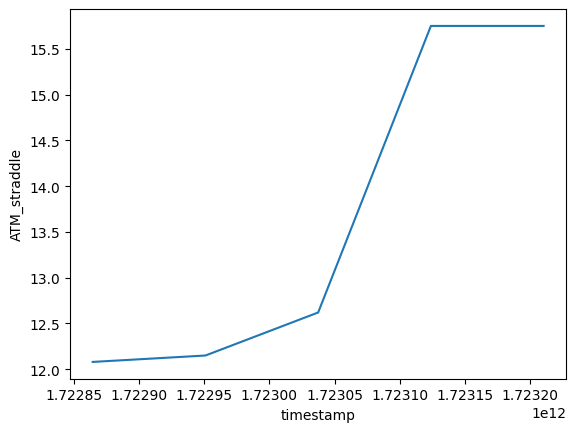

In [12]:
sns.lineplot(x='timestamp', y='ATM_straddle', data=df_at_open)

In [13]:
for n in range(len(df_at_open)):
    current_date = df_at_open.loc[n, 'date']
    print(current_date)
    print(expiration_day)
    days_left = days_until_expiration(current_date, expiration_day)
    days_left = round(int(days_left),0)
    print(f"Row {n}: Days until expiration: {days_left}")
    df_at_open.at[n, 'DTE'] = days_left
    df_at_open['day_ATM_strad'] = df_at_open['ATM_straddle'] / df_at_open['DTE']
    df_at_open['day_ATM__per'] = df_at_open['day_ATM_strad'] / df_at_open['stock_price']*100
    
    df_at_open['ATM_straddle'] = df_at_open['ATM_straddle'].astype(float)
    df_at_open['day_ATM_strad'] = df_at_open['day_ATM_strad'].astype(float)
    df_at_open['day_ATM__per'] = round(df_at_open['day_ATM__per'].astype(float),2)
    

2024-08-05
2024-08-09
Row 0: Days until expiration: 4
2024-08-06
2024-08-09
Row 1: Days until expiration: 3
2024-08-07
2024-08-09
Row 2: Days until expiration: 2
2024-08-08
2024-08-09
Row 3: Days until expiration: 1
2024-08-09
2024-08-09
Row 4: Days until expiration: 0


In [14]:
df_at_open

,date,timestamp,stock_price,fecha,ticker,strike_ATM,ATM_C,ATM_P,ATM_straddle,DTE,day_ATM_strad,day_ATM__per
0,2024-08-05,1722864600000,198.78,2024-08-05 13:30:00,AAPL,200.0,5.83,6.25,12.08,4.0,3.02,1.52
1,2024-08-06,1722951000000,206.22,2024-08-06 13:30:00,AAPL,205.0,3.5,8.65,12.15,3.0,4.05,1.96
2,2024-08-07,1723037400000,208.27,2024-08-07 13:30:00,AAPL,207.5,2.62,10.0,12.62,2.0,6.31,3.03
3,2024-08-08,1723123800000,213.06,2024-08-08 13:30:00,AAPL,212.5,1.5,14.25,15.75,1.0,15.75,7.39
4,2024-08-09,1723210200000,212.24,2024-08-09 13:30:00,AAPL,212.5,1.5,14.25,15.75,0.0,inf,inf


<Axes: xlabel='timestamp', ylabel='day_ATM__per'>

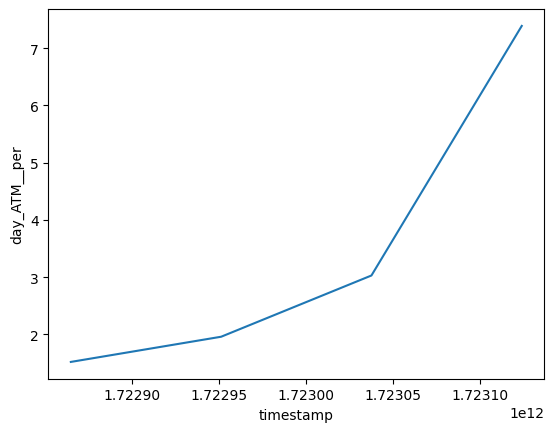

In [15]:
sns.lineplot(x='timestamp', y='day_ATM__per', data=df_at_open)